# Strategy details

This code is based on Viviana Fanelli, Mean-Reverting Statistical Arbitrage Strategies in Crude Oil Markets, Risks 2024, 12, 106.

The idea is quite straight-forward. 

In [12]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

import yfinance as yf
import warnings
from statsmodels.tsa.stattools import coint

import warnings
warnings.filterwarnings("ignore")

# This is the selected list of tickers in the paper
tickers = [
    'CL=F', # Crude Oil
    'BZ=F', # Brent Crude Oil
    # '2039.T', # Dubai Crude Oil, the data is not available on Yahoo Finance
    'HO=F', # Heating Oil, instead, we use Heating Oil Futures
]

def load_data(symbol):
    
    direc  =  'data/'
    os.makedirs(direc, exist_ok = True)
    file_name = os.path.join(direc, symbol + '.csv')

    if not os.path.exists(file_name):
        ticker = yf.Ticker(symbol)
        df = ticker.history(start='2008-01-02', end='2024-05-31')
        df.to_csv(file_name)

    df = pd.read_csv(file_name, index_col=0)
    df.index = pd.to_datetime(df.index, utc=True).date

    df['next_day_return'] = (df['Close']/df['Open']-1).shift(-1)

    return df

data = {symbol: load_data(symbol) for symbol in tickers}

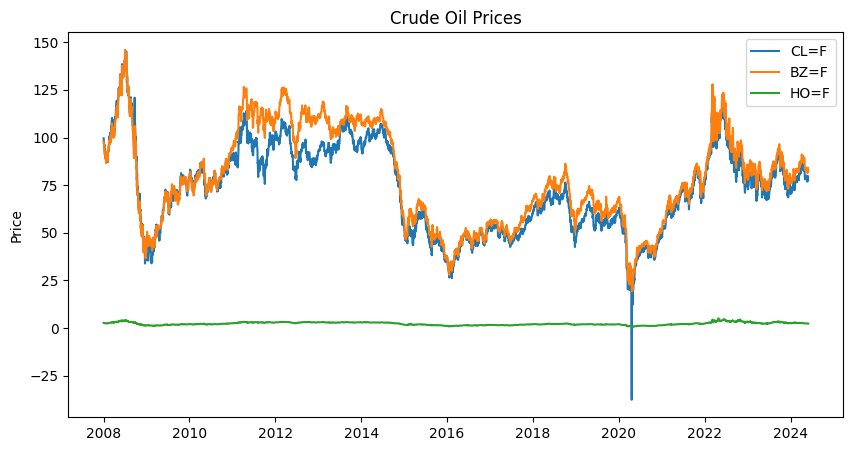

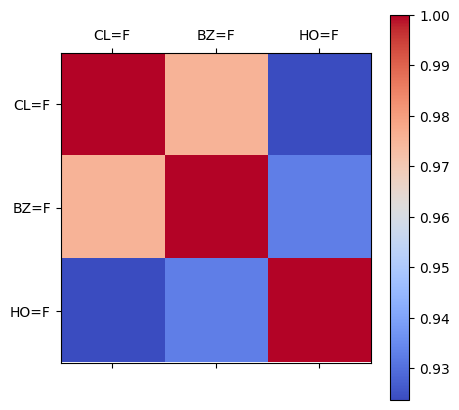

In [13]:
# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for symbol, df in data.items():
    ax.plot(df.index, df['Close'], label=symbol)

ax.set_title('Crude Oil Prices')
ax.set_ylabel('Price')
ax.legend()
plt.show()

# Plot the correlation matrix
df = pd.concat([df['Close'] for df in data.values()], axis=1)
df.columns = tickers
corr = df.corr()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
im = ax.matshow(corr, cmap='coolwarm')
ax.set_xticks(range(len(tickers)))
ax.set_yticks(range(len(tickers)))
ax.set_xticklabels(tickers)
ax.set_yticklabels(tickers)
fig.colorbar(im)
plt.show()

# Analysis of the results

Based on these results, we can see that there could be opportunities for stat arb trading.
The prices are highly correlated and the underlying products are coming from a single source: oil.

Let's see if we can make something useful out of it.

The paper suggest using ADF test. But here's the algorithm that I will do:\
For a rolling window of T:\
    - Check the ADF test\
    - If ADF is significant, conduct a regression\
    - If the last day residuals is more than 2 sigma of the residuals, then we have a signal

In [14]:
# Get the unique dates
unique_dates = sorted(df.index.unique())

W = 66 # Window size
sigma_ratio = 1.0 # Sigma ratio

holder = []
for ticker1, ticker2 in combinations(tickers, 2):

    daily_returns_holder = []
    for i, date in enumerate(unique_dates):
        daily_returns = []

        if i < W:
            continue

        start_date = unique_dates[i-W]

        df1 = data[ticker1].loc[start_date: date, :].copy()
        df2 = data[ticker2].loc[start_date: date, :].copy()

        # Concat the close prices
        df1 = df1[['Close', 'next_day_return']]
        df2 = df2[['Close', 'next_day_return']]
        df1.columns = [ticker1, f'{ticker1}_next_day_return']
        df2.columns = [ticker2, f'{ticker2}_next_day_return']
        df = pd.concat([df1, df2], axis=1)
        
        # Dropna
        df = df.dropna()

        # Check for cointegration
        spread = df[ticker1] - df[ticker2]
        score, pvalue, _ = coint(df[ticker1], df[ticker2])
        
        if pvalue > 0.1:
            daily_returns_holder.append((date, 0))
            continue
        print (f'{ticker1} and {ticker2} are cointegrated at {date}', end='\r')

        mu = spread.mean()
        sigma = spread.std()
        z_score = (spread[-1] - mu)/sigma

        if z_score > sigma_ratio:
            # Short spread
            daily_returns.append(df[ticker1+'_next_day_return'].iloc[-1])
            daily_returns.append(-df[ticker2+'_next_day_return'].iloc[-1])
            print (f'Short spread for {ticker1} and {ticker2} at {date}', end='\r')

        elif z_score < -sigma_ratio:
            # Long spread
            daily_returns.append(-df[ticker1+'_next_day_return'].iloc[-1])
            daily_returns.append(df[ticker2+'_next_day_return'].iloc[-1])
            print (f'Long spread for {ticker1} and {ticker2} at {date}', end='\r')

        else:
            # No trade
            # print (f'No trade for {ticker1} and {ticker2} at {date}', end='\r')
            pass

        if len(daily_returns) > 0:
            daily_returns_holder.append((date, np.mean(daily_returns)))
        else:
            daily_returns_holder.append((date, 0))

    df = pd.DataFrame(daily_returns_holder, columns=['Date', 'Return'])
    df = df.set_index('Date')
    holder.append(df)

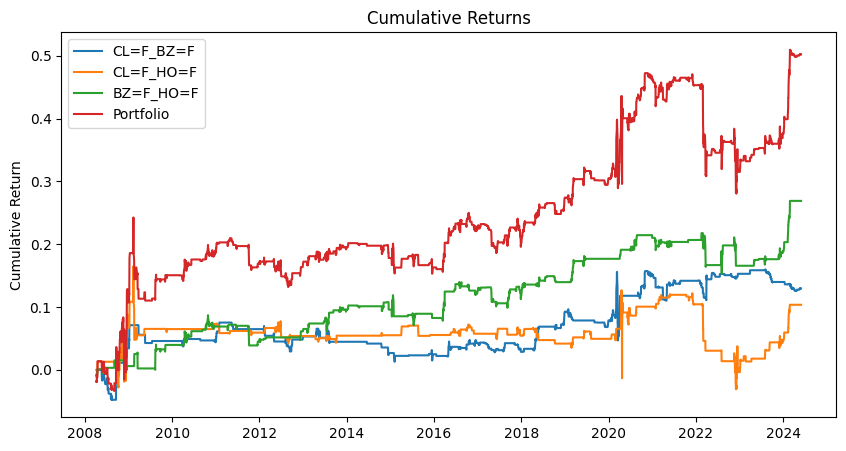

In [20]:
portfolio = pd.concat(holder, axis=1)
portfolio.columns = [f'{ticker1}_{ticker2}' for ticker1, ticker2 in combinations(tickers, 2)]
portfolio = portfolio.dropna()

# Find the max in CL=F_HO=F
max_idx = portfolio['CL=F_HO=F'].idxmax()
min_idx = portfolio['CL=F_HO=F'].idxmin()

# IMPORTANT: If you remember, some weird things happened on the 17-19 of April 2020
# Let's replace the returns with 0
portfolio.loc[max_idx] = 0
portfolio.loc[min_idx] = 0

# Portfolio combined
portfolio['Portfolio'] = portfolio.sum(axis=1)

# plot the cumsum of each pair
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for col in portfolio.columns:
    ax.plot(portfolio[col].cumsum(), label=col)

ax.set_title('Cumulative Returns')
ax.set_ylabel('Cumulative Return')
ax.legend()
plt.show()

In [21]:
# Find the sharpe, max drawdown, and sortino ratio
sharpe = portfolio.mean()/portfolio.std()*np.sqrt(252)
max_drawdown = portfolio.cumsum().cummax() - portfolio.cumsum()
sortino = portfolio.mean()/portfolio[portfolio<0].std()*np.sqrt(252)

# Combine the results into a dataframe
df = pd.concat([sharpe, max_drawdown.max(), sortino], axis=1)
df.columns = ['Sharpe', 'Max Drawdown', 'Sortino']
df = df.T

# Round to 3 decimal places
df = df.round(3)

print (df)

              CL=F_BZ=F  CL=F_HO=F  BZ=F_HO=F  Portfolio
Sharpe            0.205      0.116      0.533      0.394
Max Drawdown      0.109      0.196      0.065      0.192
Sortino           0.103      0.042      0.272      0.250


In [22]:
# Now, let's do it for weekly

# First, let's resample the data to weekly
data_weekly = {}
for symbol, df in data.items():
    df.index = pd.to_datetime(df.index)
    df = df.resample('W').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'})
    df['next_week_return'] = (df['Close']/df['Open']-1).shift(-1)
    data_weekly[symbol] = df

In [42]:
def run_analysis_weekly_basis(W, p_val_threshold, sigma_ratio):

    """
    Run the analysis for weekly basis

    Args:
    W: int, the window size
    p_val_threshold: float, the p-value threshold for cointegration
    sigma_ratio: float, the sigma ratio for the z-score

    Returns:
    df: pd.DataFrame, the portfolio returns
    """
    
    holder = []
    unique_dates = sorted(data_weekly[tickers[0]].index.unique())
    for ticker1, ticker2 in combinations(tickers, 2):

        weekly_returns_holder = []
        for i, date in enumerate(unique_dates):
            weekly_returns = []

            if i < W:
                continue

            start_date = unique_dates[i-W]

            df1 = data_weekly[ticker1].loc[start_date: date, :].copy()
            df2 = data_weekly[ticker2].loc[start_date: date, :].copy()

            # Concat the close prices
            df1 = df1[['Close', 'next_week_return']]
            df2 = df2[['Close', 'next_week_return']]
            df1.columns = [ticker1, f'{ticker1}_next_week_return']
            df2.columns = [ticker2, f'{ticker2}_next_week_return']
            df = pd.concat([df1, df2], axis=1)
            
            # Dropna
            df = df.dropna()

            # Check for cointegration
            spread = df[ticker1] - df[ticker2]
            score, pvalue, _ = coint(df[ticker1], df[ticker2])
            
            if pvalue > p_val_threshold:
                weekly_returns_holder.append((date, 0))
                continue
            print (f'{ticker1} and {ticker2} are cointegrated at {date}', end='\r')

            mu = spread.mean()
            sigma = spread.std()
            z_score = (spread[-1] - mu)/sigma

            if z_score > sigma_ratio:
                # Short spread
                weekly_returns.append(df[ticker1+'_next_week_return'].iloc[-1])
                weekly_returns.append(-df[ticker2+'_next_week_return'].iloc[-1])
                print (f'Short spread for {ticker1} and {ticker2} at {date}', end='\r')

            elif z_score < -sigma_ratio:
                # Long spread
                weekly_returns.append(-df[ticker1+'_next_week_return'].iloc[-1])
                weekly_returns.append(df[ticker2+'_next_week_return'].iloc[-1])
                print (f'Long spread for {ticker1} and {ticker2} at {date}', end='\r')

            else:
                # No trade
                # print (f'No trade for {ticker1} and {ticker2} at {date}', end='\r')
                pass

            if len(weekly_returns) > 0:
                weekly_returns_holder.append((date, np.mean(weekly_returns)))
            else:
                weekly_returns_holder.append((date, 0))

        df = pd.DataFrame(weekly_returns_holder, columns=['Date', 'Return'])
        df = df.set_index('Date')

        holder.append(df)

    portfolio_weekly = pd.concat(holder, axis=1)
    portfolio_weekly.columns = [f'{ticker1}_{ticker2}' for ticker1, ticker2 in combinations(tickers, 2)]
    portfolio_weekly = portfolio_weekly.dropna()

    # Portfolio combined
    portfolio_weekly['Portfolio'] = portfolio_weekly.sum(axis=1)

    return portfolio_weekly

max_sharpe = 0
best_params = None
for w in [12, 24, 36]:
    for p_val_threshold in [0.05, 0.1, 0.2, 0.3]:
        for sigma_ratio in [1, 2]:

            portfo = run_analysis_weekly_basis(w, p_val_threshold, sigma_ratio)
            sharpe = portfo['Portfolio'].mean()/portfo['Portfolio'].std()*np.sqrt(52)

            if sharpe > max_sharpe:
                print (f'Found better parameters: {w}, {p_val_threshold}, {sigma_ratio}, sharpe: {sharpe}')
                max_sharpe = sharpe
                best_params = (w, p_val_threshold, sigma_ratio)
                
print (best_params)

# Run the analysis with the best parameters
portfolio_weekly = run_analysis_weekly_basis(*best_params)


Found better parameters: 12, 0.2, 2, sharpe: 0.02988252529894868
Found better parameters: 12, 0.3, 1, sharpe: 0.04004207160797323
Found better parameters: 36, 0.2, 2, sharpe: 0.09592860204179741
Found better parameters: 36, 0.3, 2, sharpe: 0.1134776201352706
(36, 0.3, 2)


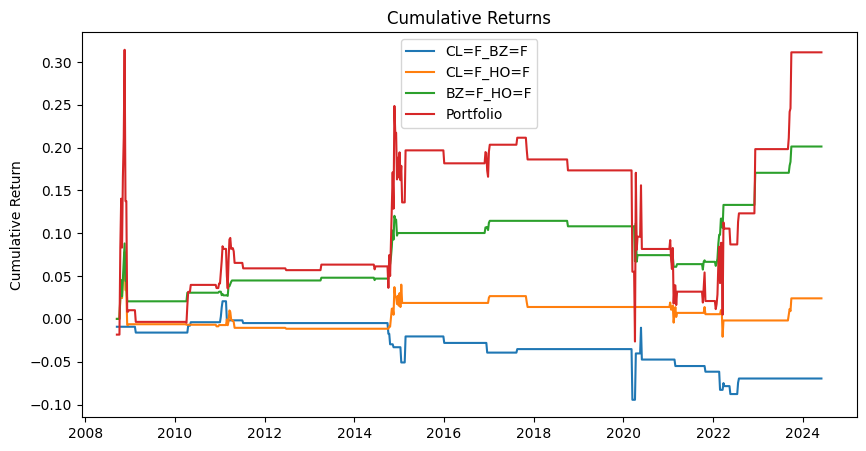

In [43]:
# Find the max in CL=F_HO=F
max_idx = portfolio_weekly['CL=F_HO=F'].idxmax()
min_idx = portfolio_weekly['CL=F_HO=F'].idxmin()

# IMPORTANT: If you remember, some weird things happened on the 17-19 of April 2020
portfolio_weekly.loc[max_idx] = 0
portfolio_weekly.loc[min_idx] = 0

# Portfolio combined
portfolio_weekly['Portfolio'] = portfolio_weekly.sum(axis=1)

# plot the cumsum of each pair
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for col in portfolio_weekly.columns:
    ax.plot(portfolio_weekly[col].cumsum(), label=col)

ax.set_title('Cumulative Returns')
ax.set_ylabel('Cumulative Return')
ax.legend()
plt.show()

In [44]:
# Find the sharpe, max drawdown, and sortino ratio
sharpe = portfolio_weekly.mean()/portfolio_weekly.std()*np.sqrt(52)
max_drawdown = portfolio_weekly.cumsum().cummax() - portfolio_weekly.cumsum()
sortino = portfolio_weekly.mean()/portfolio_weekly[portfolio_weekly<0].std()*np.sqrt(52)

# Combine the results into a dataframe
df = pd.concat([sharpe, max_drawdown.max(), sortino], axis=1)
df.columns = ['Sharpe', 'Max Drawdown', 'Sortino']
df = df.T

# Round to 3 decimal places
df = df.round(3)

print (df)

              CL=F_BZ=F  CL=F_HO=F  BZ=F_HO=F  Portfolio
Sharpe           -0.158      0.054      0.385      0.156
Max Drawdown      0.115      0.099      0.068      0.341
Sortino          -0.043      0.018      0.128      0.073


# Final thoughts:

### Limitations and differences:
1- Instead of the Dubai Crude Oil that was proposed by the original paper, I used Heating Oil futures
2- Transaction costs are not considered

### Analysis of results:
Daily trading of the proposed method, stat arb on Crude Oil market, seems to be
working quite well. The weekly trading seems not to be acceptable.

The daily trading can give us a sharpe of around 0.5 with acceptable drawdown.

Seems something interesting that can be further studied and has potentials for production.